# EDA which makes sense for the Hull Tactical Market Prediction

This EDA shows how to connect the competition dataset with real life; it analyzes the scoring function and shows how to cross-validate a model.

Reference:
- [Competition](https://www.kaggle.com/competitions/hull-tactical-market-prediction)
- Supplementary dataset: [S&P Historical Data for Hull Tactical Competition](https://www.kaggle.com/datasets/ambrosm/s-and-p-historical-data-for-hull-tactical-competition)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from colorama import Fore, Style

# Special columns

The datasets of this competition have some special columns which need an explanation. 

`train` is historical data of 9021 business days. forward_returns is the column you want to predict. `train.at[8987, 'forward_returns']` is 0.002891. This means that if you invested one dollar in S&P on day 8987 and sold it on the following day, you won 0.002891. If instead of S&P you bought a risk-free investment, you'd have gained only 0.000156 in one day. On day 8987 you would have liked to know these two figures to decide for the better investment, but because the information wasn't yet available, it could only be predicted by a regression model.

`test` is data for the period when the model is evaluated. It reflects the information *which is available* on a chosen day. On day 8987, you did not yet know that you could make 0.002891 the following night. You would only get this information one day later. For this reason, `test` has three `lagged_` columns. `test.at[8988, 'lagged_forward_returns']` is 0.002891 because on day 8988 you know that one could have earned either 0.002891 or 0.000156.

When the notebook is evaluated for the private leaderboard, `test` will contain days starting with 8990 (?), and Kaggle will present the `test` data to your model row by row. For every row that your model sees, it will have to decide where to invest.

In [2]:
train = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')
train[['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']]

,date_id,forward_returns,risk_free_rate,market_forward_excess_returns
0,0,-0.002421,0.000301,-0.003038
1,1,-0.008495,0.000303,-0.009114
2,2,-0.009624,0.000301,-0.010243
3,3,0.004662,0.000299,0.004046
4,4,-0.011686,0.000299,-0.012301
...,...,...,...,...
9016,9016,-0.000015,0.000151,-0.000477
9017,9017,-0.005199,0.000150,-0.005661
9018,9018,0.005930,0.000150,0.005467
9019,9019,0.008173,0.000150,0.007710


In [3]:
test = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/test.csv')
test[['date_id', 'is_scored', 'lagged_forward_returns', 'lagged_risk_free_rate', 'lagged_market_forward_excess_returns']]

,date_id,is_scored,lagged_forward_returns,lagged_risk_free_rate,lagged_market_forward_excess_returns
0,8980,True,0.003541,0.000161,0.003068
1,8981,True,-0.005964,0.000162,-0.006437
2,8982,True,-0.007410,0.000160,-0.007882
3,8983,True,0.005420,0.000160,0.004949
4,8984,True,0.008357,0.000159,0.007887
5,8985,True,-0.002896,0.000159,-0.003365
6,8986,True,0.002457,0.000155,0.001990
7,8987,True,0.002312,0.000156,0.001845
8,8988,True,0.002891,0.000156,0.002424
9,8989,False,0.008310,0.000156,0.007843


The features D1 and D2 are identical in the train dataset. At first, I wanted to drop one of the columns, but we don't know whether they will be different from each other in the private test set.

In [4]:
(train.D1 == train.D2).mean()

1.0

# Timelines

When working with time series, it's usually helpful to plot them in diagrams.

A plot of the cumulative forward returns resembles the development of the S&P from 1993 to 2025 (which you can see for instance at https://www.macrotrends.net/2324/sp-500-historical-chart-data). It's not an exact match; some details of the mapping will need to be worked out.

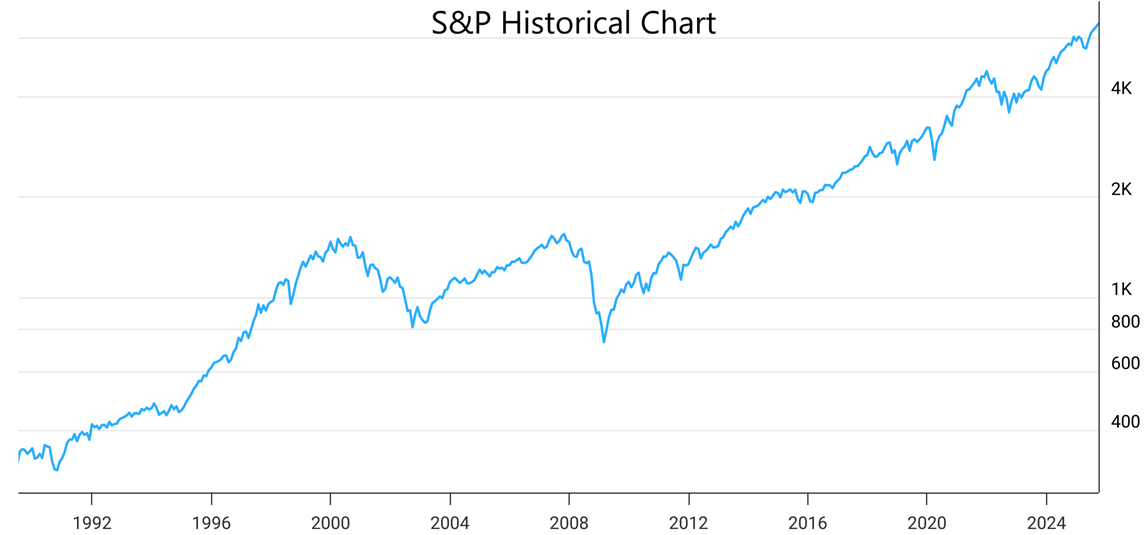
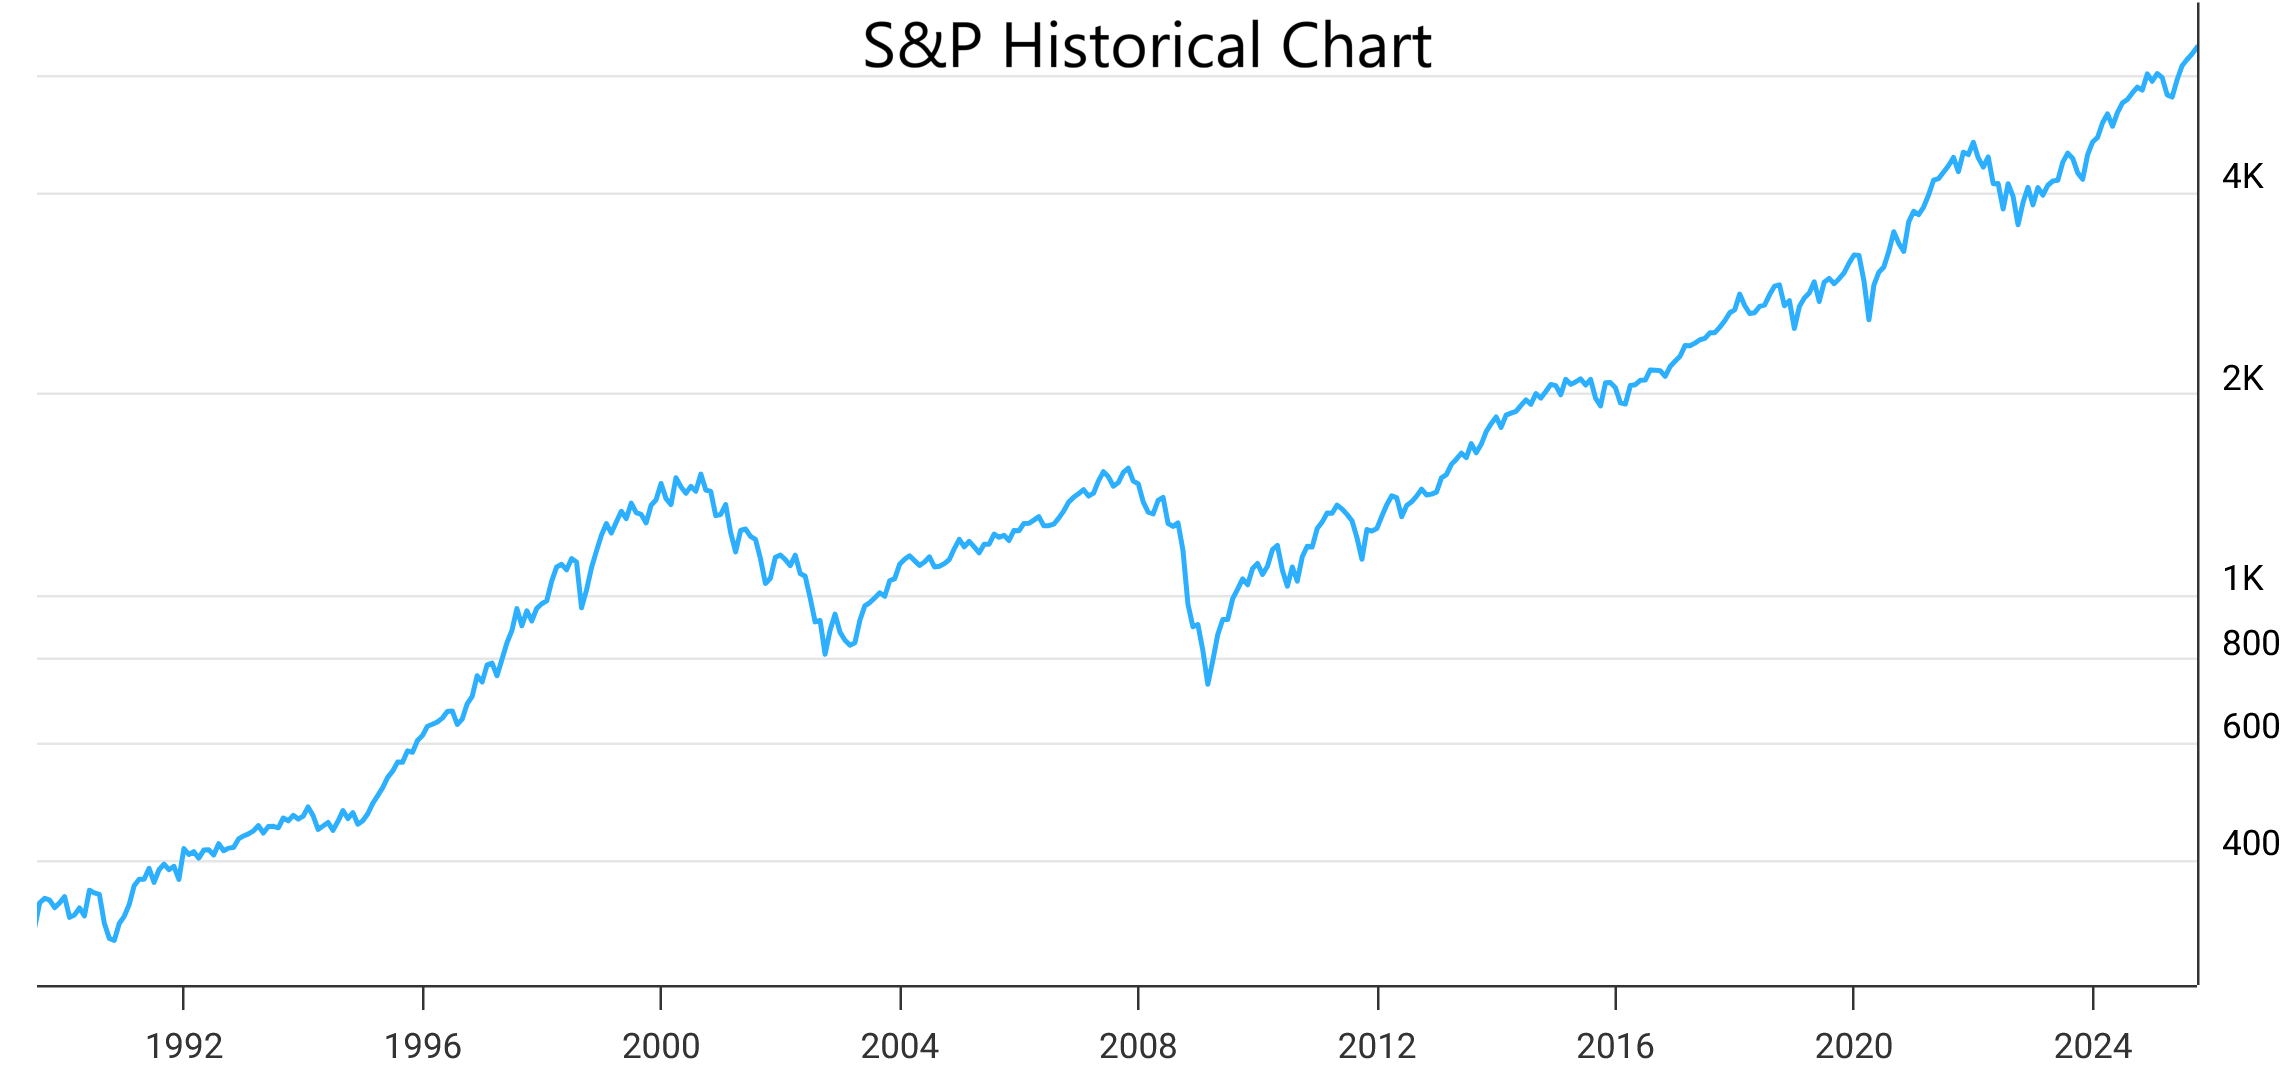

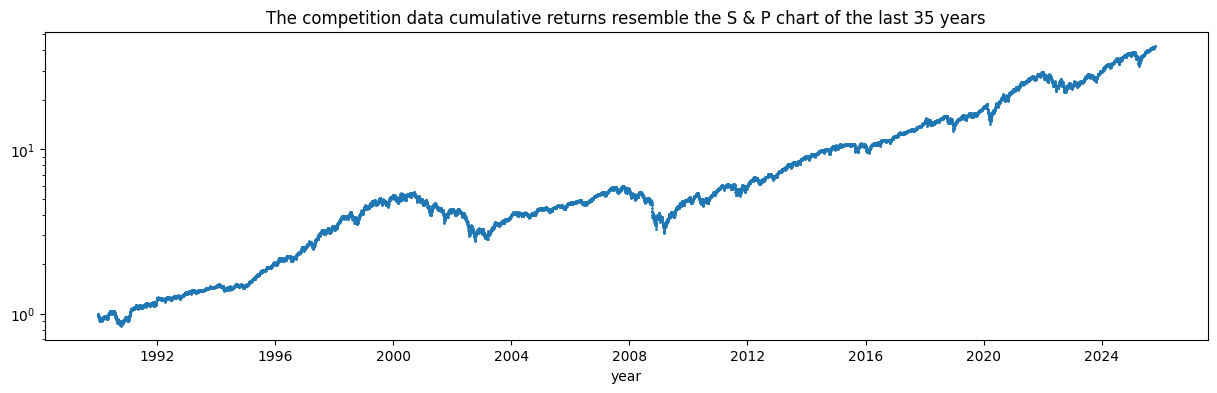

In [5]:
plt.figure(figsize=(15, 4))
plt.scatter(1990 + train.date_id / 252, (1 + train.forward_returns).cumprod(), s=1)
plt.title('The competition data cumulative returns resemble the S & P chart of the last 35 years')
plt.yscale('log')
plt.xlabel('year')
plt.xticks(np.arange(1992, 2025, 4))
plt.show()


A plot of the forward returns shows that they always are between -4 % and +4 %. Periods of high volatility alternate with periods of low volatility:

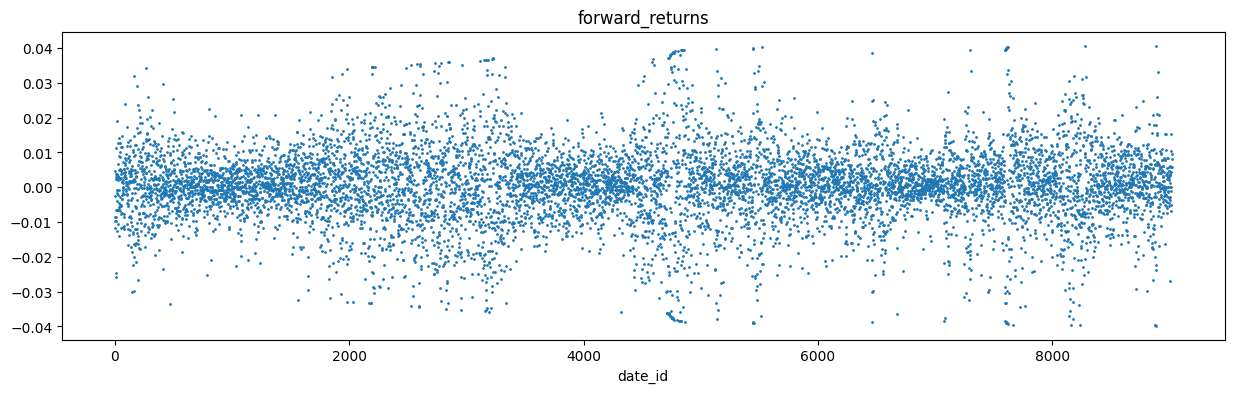

In [6]:
plt.figure(figsize=(15, 4))
plt.scatter(train.date_id, train.forward_returns, s=1)
plt.title('forward_returns')
plt.xlabel('date_id')
plt.show()

The competition's `train.csv` contains a `date_id` but no real date. We cannot directly match the `date_id` to the day of the week or to a season of the year.

I've uploaded the dataset [S&P Historical Data for Hull Tactical Competition](https://www.kaggle.com/datasets/ambrosm/s-and-p-historical-data-for-hull-tactical-competition) which defines a bijective mapping (row by row) from `date_id` to the real calendar.

The dataset contains two files:
- sp-historical.csv represents the S&P index for the exact same days as train.csv
- spy-historical.csv represents the SPY ETF (SPDR S&P 500 ETF). Its forward returns were computed as `spy['forward_returns'] = (spy['Close'].shift(-1) + spy['Dividend'].shift(-1)) / spy['Close'] - 1`. They match the competition data quite well, but they start only in February of 1993, i.e., the first 780 days are missing. Thanks to @roberthatch for finding this connection!

In [7]:
extra_dataset_sp = pd.read_csv('/kaggle/input/s-and-p-historical-data-for-hull-tactical-competition/sp-historical.csv', parse_dates=['Date'])
extra_dataset_spy = pd.read_csv('/kaggle/input/s-and-p-historical-data-for-hull-tactical-competition/spy-historical.csv', parse_dates=['Date'], index_col='date_id')
display(extra_dataset_spy.head())

,Date,Open,High,Low,Close,Adj Close,Volume,Dividend,forward_returns
date_id,,,,,,,,,
780,1993-02-01,43.97,44.25,43.97,44.25,24.49,480500.0,0.0,0.002034
781,1993-02-02,44.22,44.38,44.13,44.34,24.54,201300.0,0.0,0.010600
782,1993-02-03,44.41,44.84,44.38,44.81,24.80,529400.0,0.0,0.004240
783,1993-02-04,44.97,45.09,44.47,45.00,24.90,531500.0,0.0,-0.000667
784,1993-02-05,44.97,45.06,44.72,44.97,24.88,492100.0,0.0,0.000000


We realize now that the competition organizers haven't specified their forward returns precisely. The returns may have been calculated on open/high/low/close values or a combination of them. Moreover they seem to have been winsorized. A scatterplot of the competition dataset versus daily returns from Yahoo Finance shows high correlation, though:

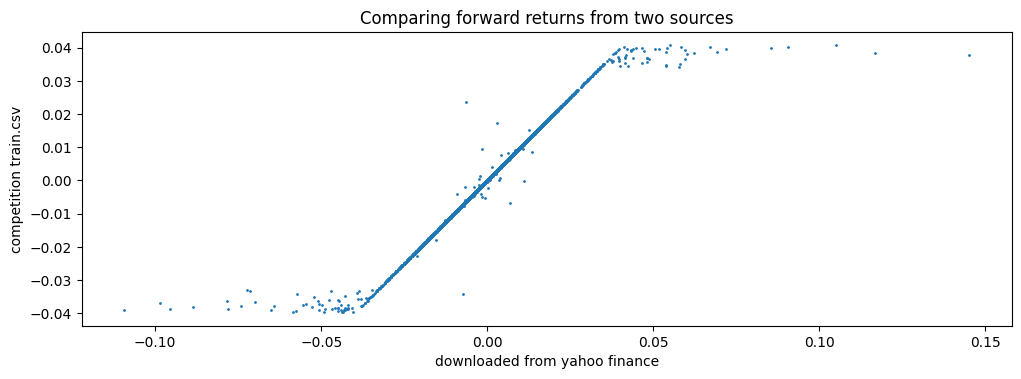

In [8]:
plt.figure(figsize=(12, 6))
plt.scatter(extra_dataset_spy.forward_returns, train.forward_returns.iloc[780:780+len(extra_dataset_spy)], s=1)
plt.gca().set_aspect('equal')
plt.xlabel('downloaded from yahoo finance')
plt.ylabel('competition train.csv')
plt.title('Comparing forward returns from two sources')
plt.savefig('return-scatter.png')
plt.show()

We can look for seasonality and compute the mean forward returns per day of the week. It looks strange that the Wednesday and Thursday returns are so much smaller than Monday, Tuesday and Friday. The same pattern can be discerned in the lagged means (shifted by one day). If you have an opinion whether these differences are significant, please tell me.

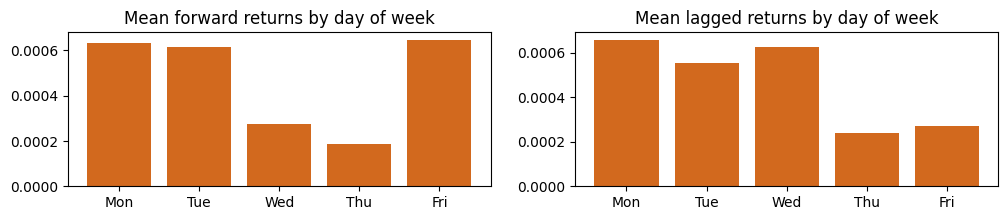

In [9]:
forward_mean_by_weekday = train.forward_returns.groupby(extra_dataset_sp.Date.dt.dayofweek).mean()
lagged_mean_by_weekday = train.forward_returns.shift(1).groupby(extra_dataset_sp.Date.dt.dayofweek).mean()
plt.figure(figsize=(12, 2))
plt.subplot(1, 2, 1)
plt.bar(forward_mean_by_weekday.index, forward_mean_by_weekday, color='chocolate')
plt.xticks(np.arange(5), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
plt.title('Mean forward returns by day of week')
plt.subplot(1, 2, 2)
plt.bar(lagged_mean_by_weekday.index, lagged_mean_by_weekday, color='chocolate')
plt.xticks(np.arange(5), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri'])
plt.title('Mean lagged returns by day of week')
plt.show()

# import scipy.stats
# train.forward_returns.groupby(extra_dataset_sp.Date.dt.dayofweek).agg(scipy.stats.sem)

The plot of the risk-free rate shows rates between 0 and 0.03 % per day, which corresponds to between 0 and 8 % per year (multiplied with 252 business days).

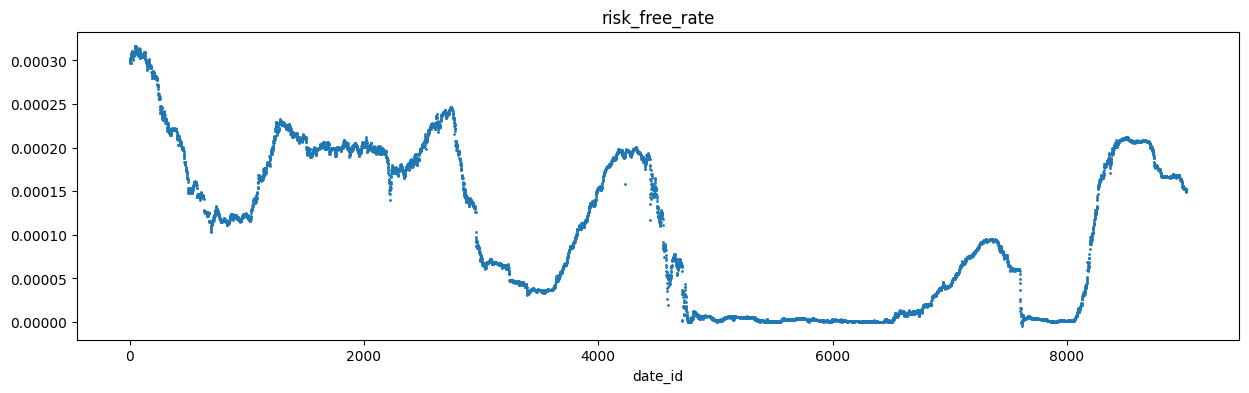

In [10]:
plt.figure(figsize=(15, 4))
plt.scatter(train.date_id, train.risk_free_rate, s=1)
plt.title('risk_free_rate')
plt.xlabel('date_id')
plt.show()

The chart of the market forward excess returns resembles the chart of the forward returns which we've seen above.

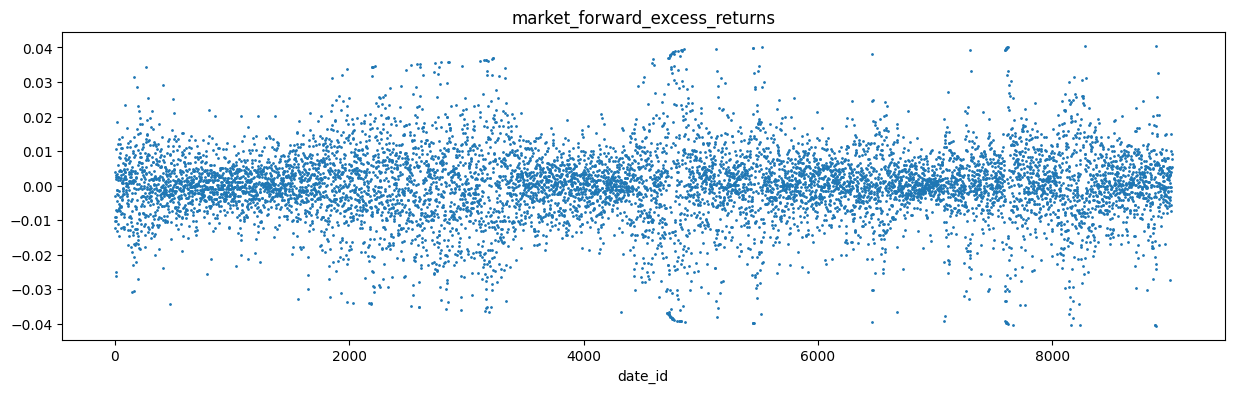

In [11]:
plt.figure(figsize=(15, 4))
plt.scatter(train.date_id, train.market_forward_excess_returns, s=1)
plt.title('market_forward_excess_returns')
plt.xlabel('date_id')
plt.show()

The difference between forward returns and market forward excess returns resembles the chart of the risk-free rate:

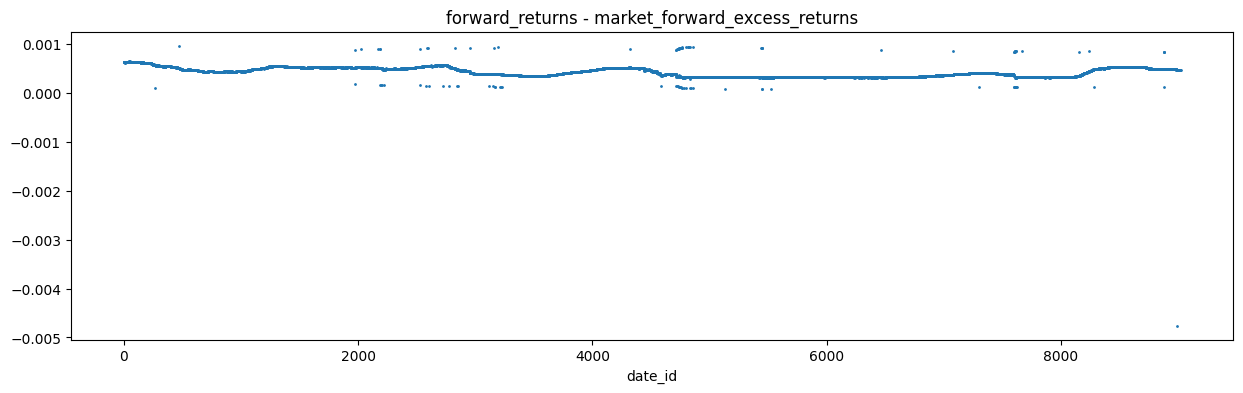

In [12]:
plt.figure(figsize=(15, 4))
plt.scatter(train.date_id, train.forward_returns - train.market_forward_excess_returns, s=1)
plt.title('forward_returns - market_forward_excess_returns')
plt.xlabel('date_id')
plt.show()

# Understanding the competition task and the scoring function

Having seen the most important columns of the dataset, we now want to understand the competition task and the scoring.

The task: Every day, we have to decide how much of our money we invest in S & P. Our allocation must be between 0 and 2:
- 0 means that we don't invest in S & P at all but get only the risk-free rate.
- 1 means that we invest all our money in S & P.
- 2 means that we invest twice our capital in S & P while taking a credit at the risk-free rate.

The simplest possible strategy works with a constant allocation: Every day, we invest the same fraction of the capital in S & P. We now plot the score that we'd get for constant allocations between 0 and 2:

In [13]:
MIN_INVESTMENT = 0
MAX_INVESTMENT = 2


class ParticipantVisibleError(Exception):
    pass


def score(solution: pd.DataFrame, submission: pd.DataFrame, row_id_column_name: str) -> float:
    """
    Calculates a custom evaluation metric (volatility-adjusted Sharpe ratio).

    This metric penalizes strategies that take on significantly more volatility
    than the underlying market.

    Returns:
        float: The calculated adjusted Sharpe ratio.
    """
    solution = solution
    solution['position'] = submission['prediction']

    if solution['position'].max() > MAX_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].max()} exceeds maximum of {MAX_INVESTMENT}')
    if solution['position'].min() < MIN_INVESTMENT:
        raise ParticipantVisibleError(f'Position of {solution["position"].min()} below minimum of {MIN_INVESTMENT}')

    solution['strategy_returns'] = solution['risk_free_rate'] * (1 - solution['position']) + solution['position'] * solution['forward_returns']

    # Calculate strategy's Sharpe ratio
    strategy_excess_returns = solution['strategy_returns'] - solution['risk_free_rate']
    strategy_excess_cumulative = (1 + strategy_excess_returns).prod()
    strategy_mean_excess_return = (strategy_excess_cumulative) ** (1 / len(solution)) - 1
    strategy_std = solution['strategy_returns'].std()

    trading_days_per_yr = 252
    if strategy_std == 0:
        raise ZeroDivisionError
    sharpe = strategy_mean_excess_return / strategy_std * np.sqrt(trading_days_per_yr)
    strategy_volatility = float(strategy_std * np.sqrt(trading_days_per_yr) * 100)

    # Calculate market return and volatility
    market_excess_returns = solution['forward_returns'] - solution['risk_free_rate']
    market_excess_cumulative = (1 + market_excess_returns).prod()
    market_mean_excess_return = (market_excess_cumulative) ** (1 / len(solution)) - 1 # train: 0.0003066067595838273
    market_std = solution['forward_returns'].std()
    
    market_volatility = float(market_std * np.sqrt(trading_days_per_yr) * 100) # train: 16.748459963166347 %
    
    # Calculate the volatility penalty
    excess_vol = max(0, strategy_volatility / market_volatility - 1.2) if market_volatility > 0 else 0
    vol_penalty = 1 + excess_vol

    # Calculate the return penalty
    return_gap = max(
        0,
        (market_mean_excess_return - strategy_mean_excess_return) * 100 * trading_days_per_yr,
    )
    return_penalty = 1 + (return_gap**2) / 100

    # Adjust the Sharpe ratio by the volatility and return penalty
    adjusted_sharpe = sharpe / (vol_penalty * return_penalty)
    try:
        intermediate_res.append((strategy_mean_excess_return, strategy_std, sharpe, vol_penalty, return_penalty))
    except NameError:
        pass
    return min(float(adjusted_sharpe), 1_000_000)

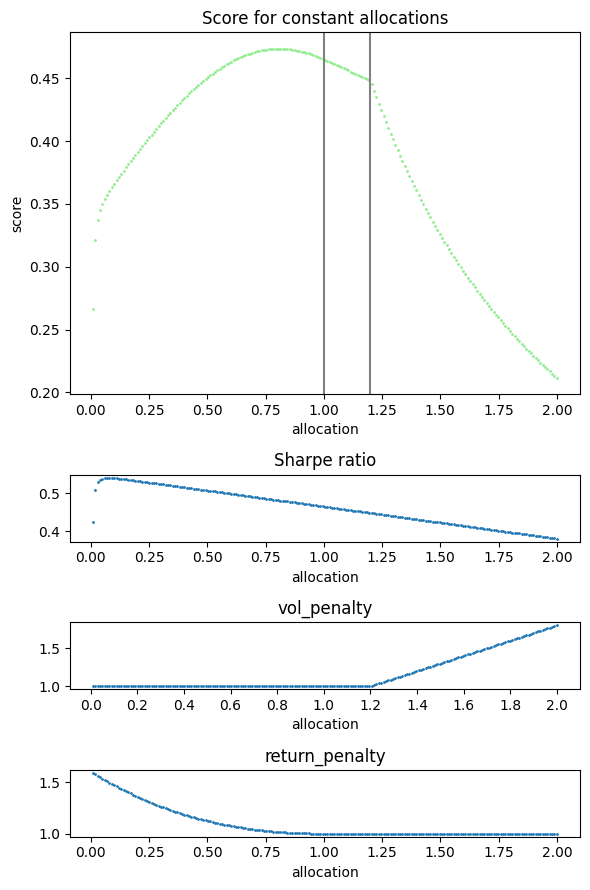

In [14]:
allocation_range = np.linspace(0, 2, 200)[1:]
res = []
intermediate_res = [] # will be filled by our modified scoring function
for allocation in allocation_range:
    submission = pd.DataFrame({'prediction': np.ones(len(train)) * allocation}, index=train.index)
    res.append(score(train.copy(), submission, ''))

plt.figure(figsize=(6, 9))
plt.subplot(6, 1, (1, 3))
plt.scatter(allocation_range, res, s=1, color='lightgreen')
plt.xlabel('allocation')
plt.ylabel('score')
plt.axvline(1, color='gray')
plt.axvline(1.2, color='gray')
plt.title('Score for constant allocations')

plt.subplot(6, 1, 4)
plt.scatter(allocation_range, [i[2] for i in intermediate_res], s=1)
plt.title('Sharpe ratio')
plt.xlabel('allocation')

plt.subplot(6, 1, 5)
plt.scatter(allocation_range, [i[3] for i in intermediate_res], s=1)
plt.xticks(np.linspace(0, 2, 11))
plt.title('vol_penalty')
plt.xlabel('allocation')

plt.subplot(6, 1, 6)
plt.scatter(allocation_range, [i[4] for i in intermediate_res], s=1)
plt.title('return_penalty')
plt.xlabel('allocation')

plt.tight_layout()
plt.show()


The diagrams show:
1. We get the highest score with a constant allocation near 0.8.
2. The Sharpe ratio doesn't depend much on our strategy. With every constant strategy, the Sharpe ratio is between 0.4 and 0.5.
3. Allocations above 1.2 get punished with a volatility penalty: The volatility penalty is defined as the difference between our strategy's volatility and 1.2 times the market volatility.
4. Allocations below 1.0 get punished with a return penalty: The return penalty is the square of how much our strategy is below an allocation of 1.0 in S & P.

In short: We want to allocate our money so that we get high returns with bounded volatility.

For details see the [source code of the scoring function](https://www.kaggle.com/code/metric/hull-competition-sharpe).

# A simple allocation strategy based on the previous quarter's volatility

Having seen that the time series has alternating periods of high and low volatility, we can define a simple strategy: If the previous quarter's volatility is low, make a high allocation and vice versa.

This strategy gives us a score of 0.53 on the training data, somewhat more than the constant strategy:

In [15]:
# The parameters w, f and o were determined by trial and error
w = 80
f = 45
o = 0.006
train['last_week_volatility'] = train['forward_returns'].rolling(window=w).std().shift(1).fillna(0.04)
intermediate_res = []
submission = pd.DataFrame({'prediction': 1 + o * f - train['last_week_volatility'] * f}, index=train.index).clip(0, 2)
print(f"Score: {score(train.copy(), submission, '')}")
print(f"Volatility penalty: {intermediate_res[-1][3]:.2f} (1.00 is the optimum)")
print(f"Return  penalty:    {intermediate_res[-1][4]:.2f} (1.00 is the optimum)")


Score: 0.531332663392413
Volatility penalty: 1.00 (1.00 is the optimum)
Return  penalty:    1.01 (1.00 is the optimum)


The two diagrams show that indeed in periods of high volatility the allocations are lower than in periods of low volatility:

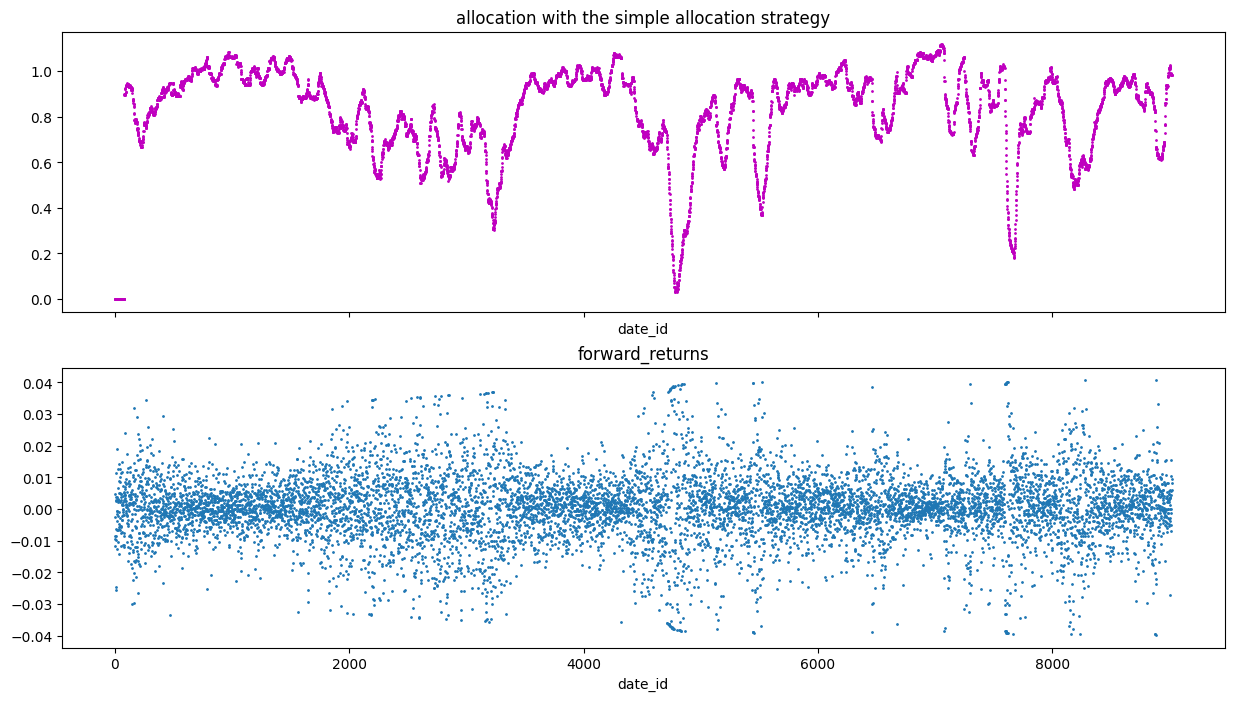

In [16]:
_, ax = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
ax[0].scatter(train.date_id, submission.prediction, s=1, color='m')
ax[0].set_title('allocation with the simple allocation strategy')
ax[0].set_xlabel('date_id')

ax[1].scatter(train.date_id, train.forward_returns, s=1)
ax[1].set_title('forward_returns')
ax[1].set_xlabel('date_id')
plt.show()


What is the weakness of this simple strategy? It optimizes only the volatility but doesn't consider the expected returns. Combine the two and you'll win the competition...

# Correct cross-validation

In the previous section of this notebook, we have computed a score for our models on the training data but we don't know how well they generalize. To evaluate the generalization capability, we need to evaluate a model on data which it hasn't seen during training.

The dataset is small: with 9021 rows it's easy to overfit, all the more if you only validate on a single train–test split. Cross-validation on mulitple folds is a necessity.

Correct cross-validation is not easy with time series. You may use the following function as a basis for cross-validation, or you can work with scikit-learn's `TimeSeriesSplit`.

Note that the [leaderboard scores are completely misleading](https://www.kaggle.com/competitions/hull-tactical-market-prediction/discussion/608088) in this competition.

In [17]:
import polars as pl

score_list_dict = {}

def cross_validate(allocation_model, label='', min_train_size=1500, test_size=120):
    """Print the validation score for allocation_model and the given train–test split.
    
    Parameters:
    allocation_model: object with methods fit and predict
    label: the name of the model
    min_train_size: minimum number of samples for training, taken from the beginning of the training dataset
    test_size: number of samples for testing, taken from the time period immediately after the training
    """
    # Read the training dataset
    train = pl.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')

    oof = np.full(len(train), np.nan)
    score_list = []
    for fold, test_start in enumerate(range(len(train) - test_size, min_train_size, - test_size)):
    
        # Split into train and test
        # test has lagged targets rather than current targets
        test_preliminary = train.slice(test_start, test_size)
        solution = pd.DataFrame(test_preliminary.select('forward_returns', 'risk_free_rate'),
                                columns=['forward_returns', 'risk_free_rate'])
        lagged = train.slice(test_start - 1, test_size)
        test = (
            test_preliminary
            .drop('forward_returns', 'risk_free_rate', 'market_forward_excess_returns')
            .with_columns(
                lagged.get_column('forward_returns').alias('lagged_forward_returns'),
                lagged.get_column('risk_free_rate').alias('lagged_risk_free_rate'),
                lagged.get_column('market_forward_excess_returns').alias('lagged_market_forward_excess_returns'),
            )
        )
        del test_preliminary
        train1 = train.slice(0, test_start)
        # print(train1)
        # print(test)
    
        # Fit the model
        allocation_model.fit(train1)
    
        # Predict for validation
        assert test['date_id'].is_sorted()
        allocation_list = []
        batch_ids = test['date_id'].unique(maintain_order=True).to_list()
        for batch_id in batch_ids:
            test_batch = test.filter(pl.col('date_id') == batch_id)
            allocation_list.append(allocation_model.predict(test_batch))
    
        # Score the validation predictions of this fold
        allocation_list = np.array(allocation_list, dtype=np.float32)
        submission = pl.DataFrame({'prediction': allocation_list})
        validation_score = score(solution, submission, '')
        vol_penalty = intermediate_res[-1][3]
        return_penalty = intermediate_res[-1][4]
        if fold <= 2 or fold >= 59:
            print(f"# Fold {fold:2} train(:{test_start:4}) test({test_start:4}:{test_start+test_size:4}) val_score: {validation_score:6.3f} {vol_penalty=:.2f} {return_penalty=:.2f}")
        if fold == 2:
            print('...')
        oof[test_start:test_start+test_size] = allocation_list
        score_list.append(validation_score)

    # Score the validation predictions overall
    print(f"{Fore.RED}# Average validation score: {np.array(score_list).mean():6.3f}", end='   ')
    solution = pd.DataFrame(train.select('forward_returns', 'risk_free_rate'),
                                columns=['forward_returns', 'risk_free_rate'])
    submission = pl.DataFrame({'prediction': oof[np.isfinite(oof)]})
    validation_score = score(solution[np.isfinite(oof)].copy(), submission, '')
    print(f"Overall validation score: {validation_score:6.3f} {label}{Style.RESET_ALL}")
    score_list_dict[label] = score_list

    # Show a histogram of the predictions
    plt.figure(figsize=(6, 2))
    plt.hist(oof, bins=np.linspace(0, 2, 81), density=True, color='c')
    plt.title(f'Allocation histogram of {label}')
    plt.gca().get_yaxis().set_visible(False)
    plt.show()


We define two models and compare them with the cross-validation function. The models have functions `fit()` and `predict()`, but the calling convention differs from scikit-learn: `predict()` doesn't predict a target but decides how many funds to allocate to S&P.

The LinearAllocationModel scores slightly better than the ConstantAllocationModel:

# Fold  0 train(:8901) test(8901:9021) val_score:  2.153 vol_penalty=1.00 return_penalty=1.56
# Fold  1 train(:8781) test(8781:8901) val_score: -1.130 vol_penalty=1.00 return_penalty=1.00
# Fold  2 train(:8661) test(8661:8781) val_score:  1.378 vol_penalty=1.00 return_penalty=1.18
...
# Fold 59 train(:1821) test(1821:1941) val_score:  1.187 vol_penalty=1.00 return_penalty=1.32
# Fold 60 train(:1701) test(1701:1821) val_score:  1.619 vol_penalty=1.00 return_penalty=1.29
# Fold 61 train(:1581) test(1581:1701) val_score:  0.519 vol_penalty=1.00 return_penalty=1.01
# Average validation score:  0.611   Overall validation score:  0.455 ConstantAllocationModel 0.8


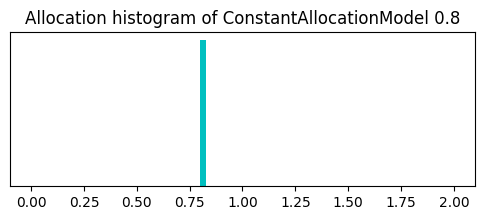

# Fold  0 train(:8901) test(8901:9021) val_score:  3.336 vol_penalty=1.00 return_penalty=1.00
# Fold  1 train(:8781) test(8781:8901) val_score: -0.937 vol_penalty=1.00 return_penalty=1.25
# Fold  2 train(:8661) test(8661:8781) val_score:  1.596 vol_penalty=1.00 return_penalty=1.00
...
# Fold 59 train(:1821) test(1821:1941) val_score:  1.534 vol_penalty=1.00 return_penalty=1.00
# Fold 60 train(:1701) test(1701:1821) val_score:  2.056 vol_penalty=1.00 return_penalty=1.00
# Fold 61 train(:1581) test(1581:1701) val_score:  0.501 vol_penalty=1.00 return_penalty=1.00
# Average validation score:  0.807   Overall validation score:  0.428 ConstantAllocationModel 1.2


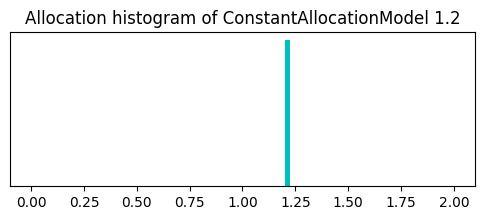

# Fold  0 train(:8901) test(8901:9021) val_score:  3.374 vol_penalty=1.00 return_penalty=1.00
# Fold  1 train(:8781) test(8781:8901) val_score: -1.071 vol_penalty=1.00 return_penalty=1.01
# Fold  2 train(:8661) test(8661:8781) val_score:  1.615 vol_penalty=1.00 return_penalty=1.00
...
# Fold 59 train(:1821) test(1821:1941) val_score:  2.001 vol_penalty=1.00 return_penalty=1.00
# Fold 60 train(:1701) test(1701:1821) val_score:  2.227 vol_penalty=1.00 return_penalty=1.00
# Fold 61 train(:1581) test(1581:1701) val_score:  0.908 vol_penalty=1.00 return_penalty=1.00
# Average validation score:  0.866   Overall validation score:  0.482 LinearAllocationModel


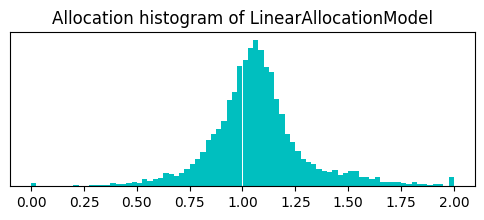

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge

class ConstantAllocationModel:
    """A model which ignores all features and always predicts the allocation given to __init__"""
    def __init__(self, constant_allocation):
        self.constant_allocation = constant_allocation
        
    def fit(self, train: pl.DataFrame):
        pass

    def predict(self, test: pl.DataFrame) -> float:
        """Return the optimal allocation between 0.0 and 2.0.
        
        Parameter:
        test: polars DataFrame with a single row (which is ignored)
        """
        return self.constant_allocation
        
class LinearAllocationModel:
    """A linear model which predicts returns based on a feature subset and
    computes the allocation as a function of the predicted returns.
    
    This model neglects the volatility."""
    vars_to_keep = ['M3', 'V2', 'P13', 'E14', 'S5', 'S4', 'S11',
                    'P10', 'P8', 'E3', 'P6', 'E20', 'P11', 'M12']

    def __init__(self):
        pass
        
    def fit(self, train: pl.DataFrame):
        train = train.select(type(self).vars_to_keep + ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns'])
        train = train.slice(1006) # the first 1006 rows have too many missing values
        self.prediction_model = make_pipeline(SimpleImputer(), Ridge())
        self.prediction_model.fit(np.array(train.select(type(self).vars_to_keep)),
                                  train.get_column('forward_returns'))

    def predict(self, test: pl.DataFrame) -> float:
        """Return the optimal allocation between 0.0 and 2.0.
        
        Parameter:
        test: polars DataFrame with a single row
        """
        predicted_returns = self.prediction_model.predict(
            np.array(test.select(type(self).vars_to_keep))
        )
        predicted_returns = predicted_returns.item()
        allocation = predicted_returns * 150 + 1
        return np.clip(allocation, 0, 2)

test_size = 200
cross_validate(ConstantAllocationModel(0.8), label='ConstantAllocationModel 0.8')
cross_validate(ConstantAllocationModel(1.2), label='ConstantAllocationModel 1.2')
cross_validate(LinearAllocationModel(), label='LinearAllocationModel')
# Average validation score:  0.607   Overall validation score:  0.451 ConstantAllocationModel
# Average validation score:  0.902   Overall validation score:  0.475 LinearAllocationModel


Note the huge difference between the average validation score (average of the per-fold scores) and the overall validation score. This difference is a consequence of the competition metric: The expected volatility in a 100-day fold is smaller than the expected volatility over a 35-year period.

Plotting the single-fold scores, we see that in most folds the LinearAllocationModel scores higher than the ConstantAllocationModel:

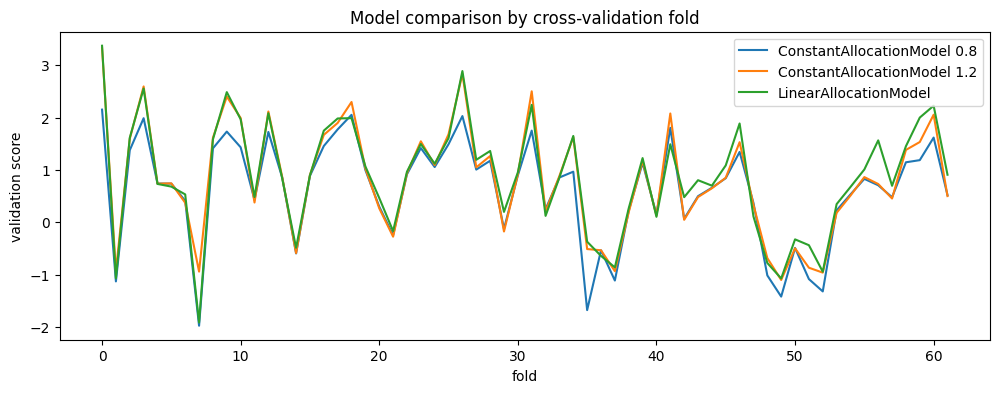

In [19]:
plt.figure(figsize=(12, 4))
for k, v in score_list_dict.items():
    plt.plot(v, label=k)
plt.legend()
plt.xlabel('fold')
plt.ylabel('validation score')
plt.title('Model comparison by cross-validation fold')
plt.show()

As you can see, the validation scores depend very much on the time period chosen. That's life: financial markets have good years and bad years.

# Insight

This time series competition is not simply about predicting a target with minimal error. Beyond predicting the target (the expected returns), we need to quantify our prediction's uncertainty (the volatility). And then we don't simply submit the predictions but optimize our money allocation given these predictions and the quantified uncertainty.

Good luck!